# Tutorial


### Example with a 2D Uniform Distribution

This example generates a 2D random uniform distribution. We will use these points to show how you can use `Grid` and `GriSPy` to index and query for neighbors.

Keep in mind that the class `Grid` provides the funcitonality needed to index the points. The class `GriSPy` inherits from `Grid` all its functionalities and adds the relevant methods to perform neighbors queries: `set_periodicity`, `bubble_neighbors`, `shell_neighbors` and `nearest_neighbors`. For completeness, we will show the example using `GriSPy`.

----------------------------------------------------------------
### Table of Contents

* [Create a random distribution of points](#section1)

* [Index the points with Grid/GriSPy](#section2)
    
* [Creating your curstom distance function](#section3)
----------------------------------------------------------------

# Create a random distribution of points  <a class="anchor" id="section1"></a>

### Import GriSPy and others packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import grispy as gsp

### Create random points and centres

In [2]:
Npoints = 10 ** 3
Ncentres = 2
dim = 2
Lbox = 100.0

rng = np.random.default_rng(seed=0)
data = rng.uniform(0, Lbox, size=(Npoints, dim))
centres = rng.uniform(0, Lbox, size=(Ncentres, dim))

# Index the points with Grid/GriSPy  <a class="anchor" id="section2"></a>

In [3]:
grid = gsp.GriSPy(data, N_cells=32)

You can get some information about the grid using some helpfull methods:

In [4]:
grid.shape   # number of cells per dimension

(32, 32)

In [5]:
grid.edges   # grid edges in each dimension

array([[2.97613690e-01, 1.90001607e-02],
       [9.99501352e+01, 9.98067457e+01]])

In [6]:
digits = grid.cell_digits(centres)   # check the cell indices (or digits) where a given set of points would fall
digits

array([[31,  1],
       [29,  8]], dtype=int16)

This means that from the 2 input points, the first would be located in the cell (31, 1) and the second in (29, 8).

In [7]:
grid.cell_count(digits)   # number of points in the array `data` that where indexed at initialization

array([2, 0])

In [8]:
grid.cell_centre(digits)    # position of each cell centre

array([[98.39306458,  4.69655073],
       [92.16478198, 26.52512006]])

The digits of cells can be used in other useful methods like `cell_walls` or `cell_points`.

Another important method is `contains` which shows if a given set of new points are contained by the grid.

In [9]:
points = np.array([
    [30., 50.], 
    [-10., -10.]
])
grid.contains(points)

array([ True, False])

### Set periodicity conditions

Set periodicity conditions on x-axis (or axis=0) and y-axis (or axis=1)

In [10]:
periodic = {0: (0, Lbox), 1: (0, Lbox)}
grid.set_periodicity(periodic, inplace=True)
grid

GriSPy(N_cells=32, copy_data=False, periodic={0: (0, 100.0), 1: (0, 100.0)}, metric='euclid')

Also you can build a periodic grid in the same step

In [11]:
grid = gsp.GriSPy(data, periodic=periodic)

**Important:** Periodic boundaries don't have to be exactly the same as the values of `grid.edges`. The edges of the grid are computed from real data to optimize the queries on sparse data. So, there is nothing wrong on the edge of the grid being at 99.9 but the periodic boundary set exactly at 100.

### Query for neighbors within upper_radii

In [12]:
upper_radii = 10.0
bubble_dist, bubble_ind = grid.bubble_neighbors(
    centres, distance_upper_bound=upper_radii
)

### Query for neighbors in a shell within lower_radii and upper_radii

In [13]:
upper_radii = 20.0
lower_radii = 10.0
shell_dist, shell_ind = grid.shell_neighbors(
    centres,
    distance_lower_bound=lower_radii,
    distance_upper_bound=upper_radii
)

### Query for nth nearest neighbors

In [14]:
n_nearest = 10
near_dist, near_ind = grid.nearest_neighbors(centres, n=n_nearest)

### Plot results

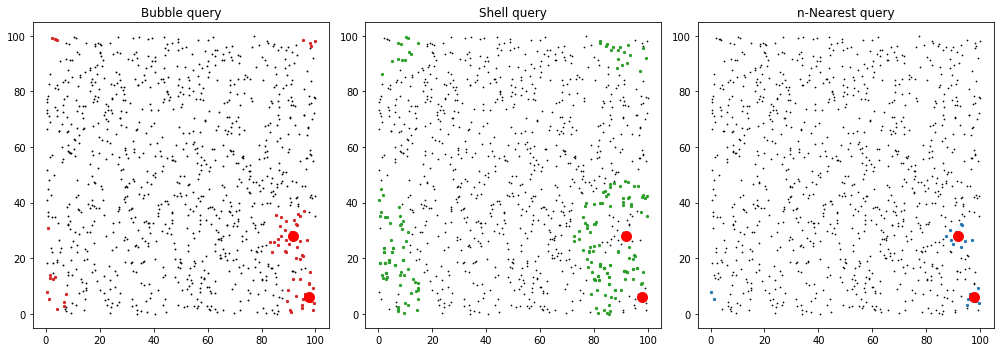

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

ax = axes[0]
ax.set_title("Bubble query")
ax.scatter(data[:, 0], data[:, 1], c="k", marker=".", s=3)
for ind in bubble_ind:
    ax.scatter(data[ind, 0], data[ind, 1], c="C3", marker="o", s=5)
ax.plot(centres[:,0],centres[:,1],'ro',ms=10)


ax = axes[1]
ax.set_title("Shell query")
ax.scatter(data[:, 0], data[:, 1], c="k", marker=".", s=2)
for ind in shell_ind:
    ax.scatter(data[ind, 0], data[ind, 1], c="C2", marker="o", s=5)
ax.plot(centres[:,0],centres[:,1],'ro',ms=10)

ax = axes[2]
ax.set_title("n-Nearest query")
ax.scatter(data[:, 0], data[:, 1], c="k", marker=".", s=2)
for ind in near_ind:
    ax.scatter(data[ind, 0], data[ind, 1], c="C0", marker="o", s=5)
ax.plot(centres[:,0],centres[:,1],'ro',ms=10)

fig.tight_layout()

# Creating your curstom distance function  <a class="anchor" id="section3"></a>

Let's assume that we intend to compare our distances using levenshtein's metric for similarity between text (https://en.wikipedia.org/wiki/Levenshtein_distance).

Luckly we have the excellent `textdistance` library that implements efficiently this distance. 

We can install it with

``` bash
$ pip install textdistance
```

and then import it with

In [16]:
import textdistance

So to make these custom distance compatible with GriSPy, we must define a function
that receives 3 parameters:
    
- `c0` the center to which we seek the distance.
- `centres` the $C$ centers to which we want to calculate the distance from
   a *c0*.
- `dim` the dimension of each center and *c0*.

Finally the function must return a `np.ndarray` with $C$ elements
where the element $j-nth$ corresponds to the distance between `c0` and `centres`$_j$.

In [17]:
def levenshtein(c0, centres, dim):
    # textdistance only operates over list and tuples
    c0 = tuple(c0)
    
    # creates a empty array with the required 
    # number of distances
    distances = np.empty(len(centres))
    for idx, c1 in enumerate(centres):
        
        # textdistance only operates over list and tuples
        c1 = tuple(c1)
        
        # calculate the distance
        dis = textdistance.levenshtein(c0, c1)
        
        # store the distance
        distances[idx] = dis
        
    return distances

Then we create the grid with the custom distance, and run the code

In [18]:
grid = gsp.GriSPy(data, metric=levenshtein)

upper_radii = 10.0
lev_dist, lev_ind = grid.bubble_neighbors(
    centres, distance_upper_bound=upper_radii)

Finally we can check our `bubble_neighbors` result with a plot

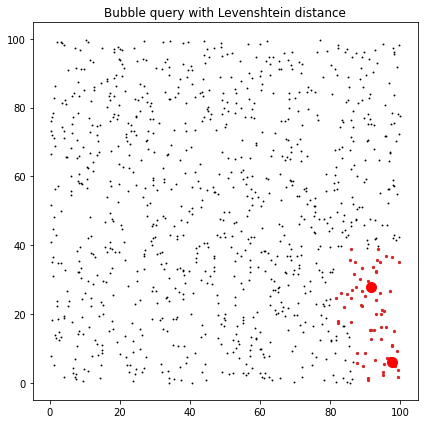

In [19]:
fig, axes = plt.subplots(figsize=(6, 6))

ax = axes
ax.set_title("Bubble query with Levenshtein distance")
ax.scatter(data[:, 0], data[:, 1], c="k", marker=".", s=3)
for ind in lev_ind:
    ax.scatter(data[ind, 0], data[ind, 1], c="C3", marker="o", s=5)
ax.plot(centres[:,0],centres[:,1],'ro',ms=10)

fig.tight_layout()